In [1]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from astropy.coordinates import solar_system_ephemeris
from poliastro.frames import Planes


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [4]:
start_date = time.Time("2037-06-13 15:01", scale="utc").tdb
search_end_date = time.Time("2037-08-25 01:01", scale="utc").tdb
end_date = time.Time("2037-12-25 01:01", scale="utc").tdb


body1=Ganymede


epoch=time_range(start=start_date, end=end_date)
io_ephem = Ephem.from_horizons(501,epochs= epoch, attractor= Jupiter)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= epoch, attractor= Jupiter)

orb_europa = Orbit.from_ephem(Jupiter, europa_ephem, start_date)
orb_callisto = Orbit.from_ephem(Jupiter, callisto_ephem, start_date)
orb_io = Orbit.from_ephem(Jupiter, io_ephem, start_date)
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)



Searching for optimal Ganymede transfer...
New best found: ΔV=4304.53 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 15:45:21.185, TOF=20.0 d
New best found: ΔV=4293.68 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 16:28:33.185, TOF=20.0 d
New best found: ΔV=4282.56 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 17:11:45.185, TOF=20.1 d
New best found: ΔV=4271.18 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 17:54:57.185, TOF=20.1 d
New best found: ΔV=4259.53 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 18:38:09.185, TOF=20.1 d
New best found: ΔV=4247.63 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 19:21:21.185, TOF=20.2 d
New best found: ΔV=4235.48 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 20:04:33.185, TOF=20.2 d
New best found: ΔV=4223.09 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 20:47:45.185, TOF=20.2 d
New best found: ΔV=4210.48 m/s, burn=2037-06-13 15:45:21.185, arrival=2037-07-03 21:30:57.185, TOF=20.2 d
New

KeyboardInterrupt: 

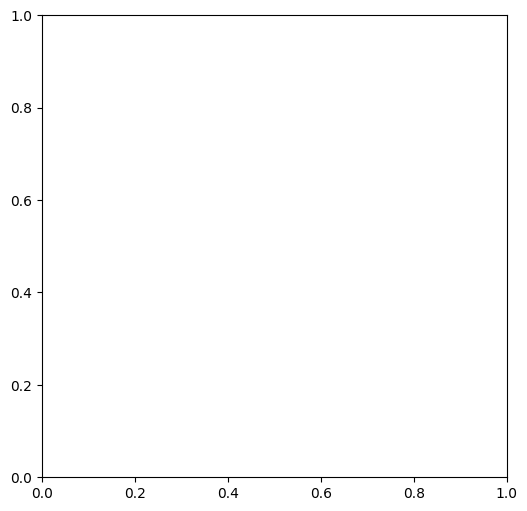

In [5]:
orb_io = Orbit.from_ephem(Jupiter, io_ephem, start_date)
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)



plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
starship_orb=Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, orb_ganymede.inc, orb_ganymede.raan, 0*u.deg, 0*u.deg,start_date, plane=Planes.EARTH_ECLIPTIC)
starship_orb = starship_orb.propagate_to_anomaly(180*u.deg)
starship_orb._epoch = start_date

# Solve for lowest DV burn to reach ganymede
# Search parameters
burn_date_resolution = 0.03*u.day  # Resolution for burn date search
tof_min = 20*u.day  # Minimum time of flight
tof_max = 80*u.day  # Maximum time of flight
tof_resolution = 0.03*u.day  # Resolution for time of flight search

delta_time = search_end_date - start_date
tof_range = np.arange(tof_min.value, tof_max.value, tof_resolution.value) * u.day

lowest_dv = 100000
lowest_date_burn = None
lowest_date_arrival = None
lowest_orb = None
arrival_v = 0

total_scans = 0
print("Searching for optimal Ganymede transfer...")

# Loop over burn dates
for i in range(1, int(delta_time / burn_date_resolution)):
    date_burn = start_date + i * burn_date_resolution
    
    # Loop over times of flight
    for tof in tof_range:
        date_arrival = date_burn + tof
        
        # Check if arrival date is within our ephemeris range
        if date_arrival > end_date:
            continue
            
        total_scans += 1
        
        try:
            ss_arrival = Orbit.from_ephem(Jupiter, ganymede_ephem, date_arrival)
            man_lambert = Maneuver.lambert(starship_orb, ss_arrival, M=0)
            burn = man_lambert[0]
            dv = np.linalg.norm(burn[1].value)
            arrival_vel = np.linalg.norm(man_lambert[1][1].value)
            
            if dv < lowest_dv:
                lowest_dv = dv
                lowest_date_burn = date_burn
                lowest_date_arrival = date_arrival
                arrival_v = arrival_vel
                lowest_orb, final = starship_orb.apply_maneuver(man_lambert, intermediate=True)
                print(f"New best found: ΔV={lowest_dv:.2f} m/s, burn={date_burn}, arrival={date_arrival}, TOF={tof.to(u.day):.1f}")
        except Exception as e:
            # Skip trajectories that fail (e.g., invalid Lambert solutions)
            pass

print(f"\n{'='*60}")
print(f"Search complete! Scanned {total_scans} trajectories.")
print(f"Lowest ΔV to reach Ganymede is {lowest_dv:.2f} m/s")
print(f"Burn date: {lowest_date_burn}")
print(f"Arrival date: {lowest_date_arrival}")
print(f"Time of flight: {(lowest_date_arrival - lowest_date_burn).to(u.day):.2f}")
print(f"V∞ speed at Ganymede is {arrival_v:.2f} m/s")
print(f"{'='*60}\n")

# Plot results
# plotter.plot(orb_europa, label="Europa Orbit")
# plotter.plot(orb_callisto, label="Callisto Orbit")
# plotter.plot(orb_io, label="Io Orbit")
plotter.plot(orb_ganymede, label="Ganymede Orbit")

plotter.plot(starship_orb, color="slategrey", label="Post JOI Orbit")
if lowest_orb is not None:
    plotter.plot(lowest_orb, color="red", label=body1.name + " Intercept Orbit")

Lowest DV to reach Ganymede is 73.83 m/s arriving at date 2037-08-24 22:42:57.184.
V infinity speed at Ganymede is 15505.53 m/s.
The Starship is in a 137500 x 10862500 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-07-13 15:02:09.184 (TDB).
The period is 83.32973111652454 d.
Speed at periapsis is 0.54 km / s, which is 4290 m / s below escape velocity at that altitude.
420363 x 423548 km x 25.5 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-07-13 15:02:09.184 (TDB)
665143 x 677146 km x 25.5 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-07-13 15:02:09.184 (TDB)
1068262 x 1073348 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-07-13 15:02:09.184 (TDB)
1870879 x 1896564 km x 25.2 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-07-13 15:02:09.184 (TDB)


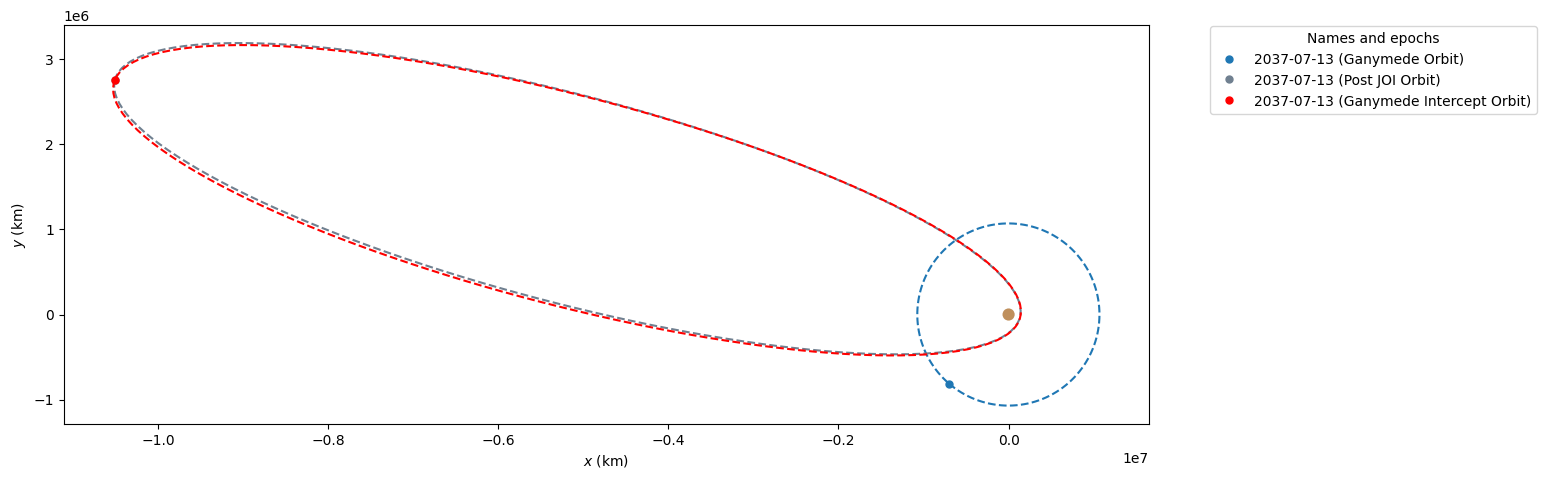

In [7]:
start_date = time.Time("2037-07-13 15:01", scale="utc").tdb
search_end_date = time.Time("2037-10-25 01:01", scale="utc").tdb
end_date = time.Time("2037-12-25 01:01", scale="utc").tdb


body1=Ganymede


epoch=time_range(start=start_date, end=end_date)
io_ephem = Ephem.from_horizons(501,epochs= epoch, attractor= Jupiter)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= epoch, attractor= Jupiter)

orb_europa = Orbit.from_ephem(Jupiter, europa_ephem, start_date)
orb_callisto = Orbit.from_ephem(Jupiter, callisto_ephem, start_date)
orb_io = Orbit.from_ephem(Jupiter, io_ephem, start_date)
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)

plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
starship_orb=Orbit.from_classical(Jupiter, 5500000*u.km, 0.975*u.one, orb_ganymede.inc, orb_ganymede.raan, 0*u.deg, 0*u.deg,start_date, plane=Planes.EARTH_ECLIPTIC)
starship_orb = starship_orb.propagate_to_anomaly(180*u.deg)
starship_orb._epoch = start_date




#solve for lowest DV burn to reach ganymede
resolution = 0.02*u.day
delta_time = search_end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
arrival_v=0
for i in range(1,int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = date_launch + 42*u.day
    ss_arrival = Orbit.from_ephem(Jupiter, ganymede_ephem, date_arrival)
    man_lambert = Maneuver.lambert(starship_orb,ss_arrival,M=0)
    burn = man_lambert[0]
    dv = np.linalg.norm(burn[1].value)
    arrival_v = np.linalg.norm(man_lambert[1][1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_arrival
        lowest_orb,final = starship_orb.apply_maneuver(man_lambert, intermediate=True)
print(f"Lowest DV to reach Ganymede is {lowest_dv:.2f} m/s arriving at date {lowest_date}.")    
print(f"V infinity speed at Ganymede is {arrival_v:.2f} m/s.")    
# #apply retrograde burn to speed elliptical orbit to one closer to Europa orbit speed
# prograde_vector = (starship_orb.v/(np.linalg.norm(starship_orb.v))).value
# burn_dv = -3.10*prograde_vector#km/s


# plotter.plot(orb_europa, label="Europa Orbit")
# plotter.plot(orb_callisto, label="Callisto Orbit")
# plotter.plot(orb_io, label="Io Orbit")
plotter.plot(orb_ganymede, label="Ganymede Orbit")
# plotter.plot_ephem(ephem, label="Europa Orbit")

#Galelio orbit starship_orb=Orbit.from_classical(Jupiter, 8500000*u.km, 0.975*u.one, 0*u.deg, 0*u.deg, 0*u.deg, 0*u.deg,start_date)
plotter.plot(starship_orb, color="slategrey",label="Post JOI Orbit")
plotter.plot(lowest_orb, color="red",label=body1.name+" Intercept Orbit")
# plotter.plot(post_burn_orbit, color="red",label="Post Retro Burn Orbit")
print(f"The Starship is in a {starship_orb}.")
print(f"The period is {starship_orb.period.to(u.day)}.")
# print(Jupiter.R)

#iffy function that only works if the above orbit definition puts the spacecraft at periapsis and does not do vector addition and basic things like that
#ie does not work
evel = Jupiter.escape_velocity_at_alt( np.linalg.norm(starship_orb.r) - Jupiter.R)
pvel = np.linalg.norm(starship_orb.v.to(u.km/u.s))

print(f"Speed at periapsis is {pvel:.2f}, which is {(evel-pvel):.0f} below escape velocity at that altitude.")

print(orb_io)
print(orb_europa)
print(orb_ganymede)
print(orb_callisto)

I then need to calculate how much this gravity assist rotates the incoming velocity vector. This seems visualy discernable. How does that translate to velocity relative to Jupiter?
The initial velocity is the spacecraft arrival velocity vector plus the speed of the moon, and the final is the rotated vector plus the speed of the moon. This might be much easier to calculate than I think. 
 

Initial orbit is 133787 x 10862848 km x 24.4 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-08-27 15:02:09.184 (TDB).
Initial speed relative to Jupiter is 14.60 km / s.
Velocity relative to Ganymede is 14.61 km / s
V infinity (relative to Ganymede) rotated by -1.9 degrees during gravity assist.
Final speed relative to Jupiter is 14.29 km / s km/s.
Final orbit is 114350 x 7810933 km x 25.3 deg (JupiterICRS) orbit around Jupiter (♃) at epoch 2037-08-27 15:02:09.184 (TDB)
Orbital period reduced from 83.29 d to 50.96 d.


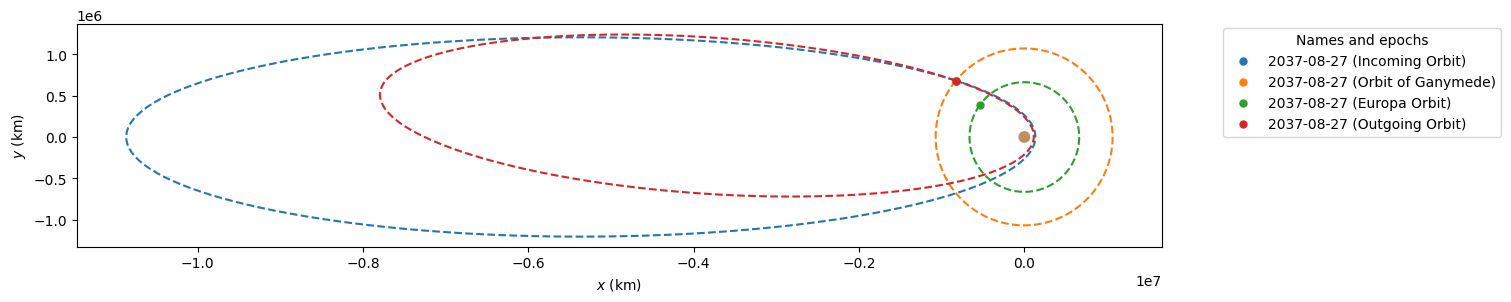

In [44]:
body1=Ganymede
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, lowest_date)
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 502
orb_europa = Orbit.from_ephem(Jupiter, europa_ephem, lowest_date)



# ephem_main =  Ephem.from_body(body1, time_range(start_date, end=end_date))
starship_arrival = lowest_orb.propagate(lowest_date - lowest_orb.epoch)
# print(body1.k.to)

print(f"Initial orbit is {starship_arrival}.")
print(f"Initial speed relative to Jupiter is {np.linalg.norm(starship_arrival.rv()[1]):.2f}.")
vel_vector_0 = starship_arrival.rv()[1]-orb_ganymede.rv()[1]

v_sc_arriv= np.linalg.norm(vel_vector_0)
print(f"Velocity relative to {body1.name} is {v_sc_arriv:.2f}")
r_p = 50*u.km+body1.R
#Est flip angle with basic calc
flip_sin=1/(1+r_p* v_sc_arriv**2/body1.k)
angle_flip = -math.asin(flip_sin)*2
print(f"V infinity (relative to {body1.name}) rotated by {angle_flip*180/math.pi:.1f} degrees during gravity assist.")


rot=scipyRot.from_euler('z',angle_flip,degrees=False)
vel_vector_1=rot.apply(vel_vector_0.value)*u.km/u.s
v_final = vel_vector_1 + orb_ganymede.rv()[1]
print(f"Final speed relative to Jupiter is {np.linalg.norm(v_final):.2f} km/s.")
final_orb=Orbit.from_vectors(Jupiter, starship_arrival.r, v_final, epoch=lowest_date)
print(f"Final orbit is {final_orb}")


plotter = StaticOrbitPlotter()
plotter.plot(starship_arrival, label="Incoming Orbit")
plotter.plot(orb_ganymede, label="Orbit of "+body1.name)
plotter.plot(orb_europa, label="Europa Orbit")

plotter.plot(final_orb, label="Outgoing Orbit")
print(f"Orbital period reduced from {starship_arrival.period.to(u.day):.2f} to {final_orb.period.to(u.day):.2f}.")

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



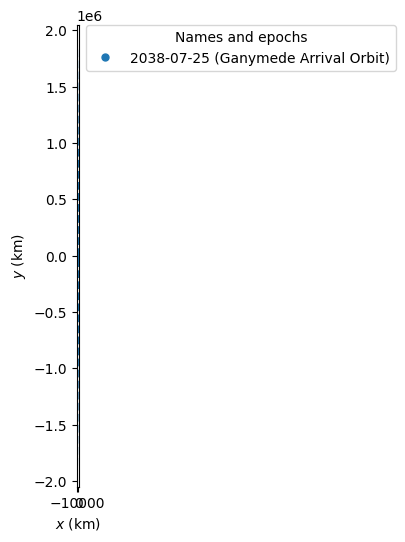

In [35]:
c3_a = np.linalg.norm(v_sc_arriv)**2

#C3 only orbit calc
a_exit = -(body1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body1.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(end_date, scale="utc"),
)


plotter = StaticOrbitPlotter()

plotter.plot(arrival_orbit, label=body1.name + " Arrival Orbit")


Ok, that was great, but we need an actual full trajectory, we ca not handwave that away, espicially when calculating radiation flux. 

We need to work out what the maximum aerobrake DV is. 